In [1]:
import os

from matplotlib import pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import vgg16

In [2]:
# from tensorflow.keras.layers.experimental.preprocessing import Rescaling
# from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

In [3]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [4]:
if IN_COLAB:
    drive.mount('/content/drive/')
    base_path = '/content/drive/MyDrive'
else:
    base_path = '.'

In [5]:
dataset_path = os.path.join(base_path, 'labeled_dataset')
train_path = os.path.join(dataset_path, 'train')
valid_path = os.path.join(dataset_path, 'valid')
test_path = os.path.join(dataset_path, 'test')

In [6]:
# t_size = (387, 632)
t_size = (224, 224)
train_batches = ImageDataGenerator(
    preprocessing_function=vgg16.preprocess_input).flow_from_directory(
        train_path, 
        target_size=t_size, 
        classes=['malignant', 'benign'], 
        shuffle = True,
        batch_size=32)
valid_batches = ImageDataGenerator(
    preprocessing_function=vgg16.preprocess_input).flow_from_directory(
        valid_path, 
        target_size=t_size, 
        classes=['malignant', 'benign'], 
        shuffle = True,
        batch_size=32)
test_batches = ImageDataGenerator(
    preprocessing_function=vgg16.preprocess_input).flow_from_directory(
        test_path, 
        target_size=t_size, 
        classes=['malignant', 'benign'], 
        shuffle = False,
        batch_size=32)

Found 2177 images belonging to 2 classes.
Found 434 images belonging to 2 classes.
Found 289 images belonging to 2 classes.


In [7]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')



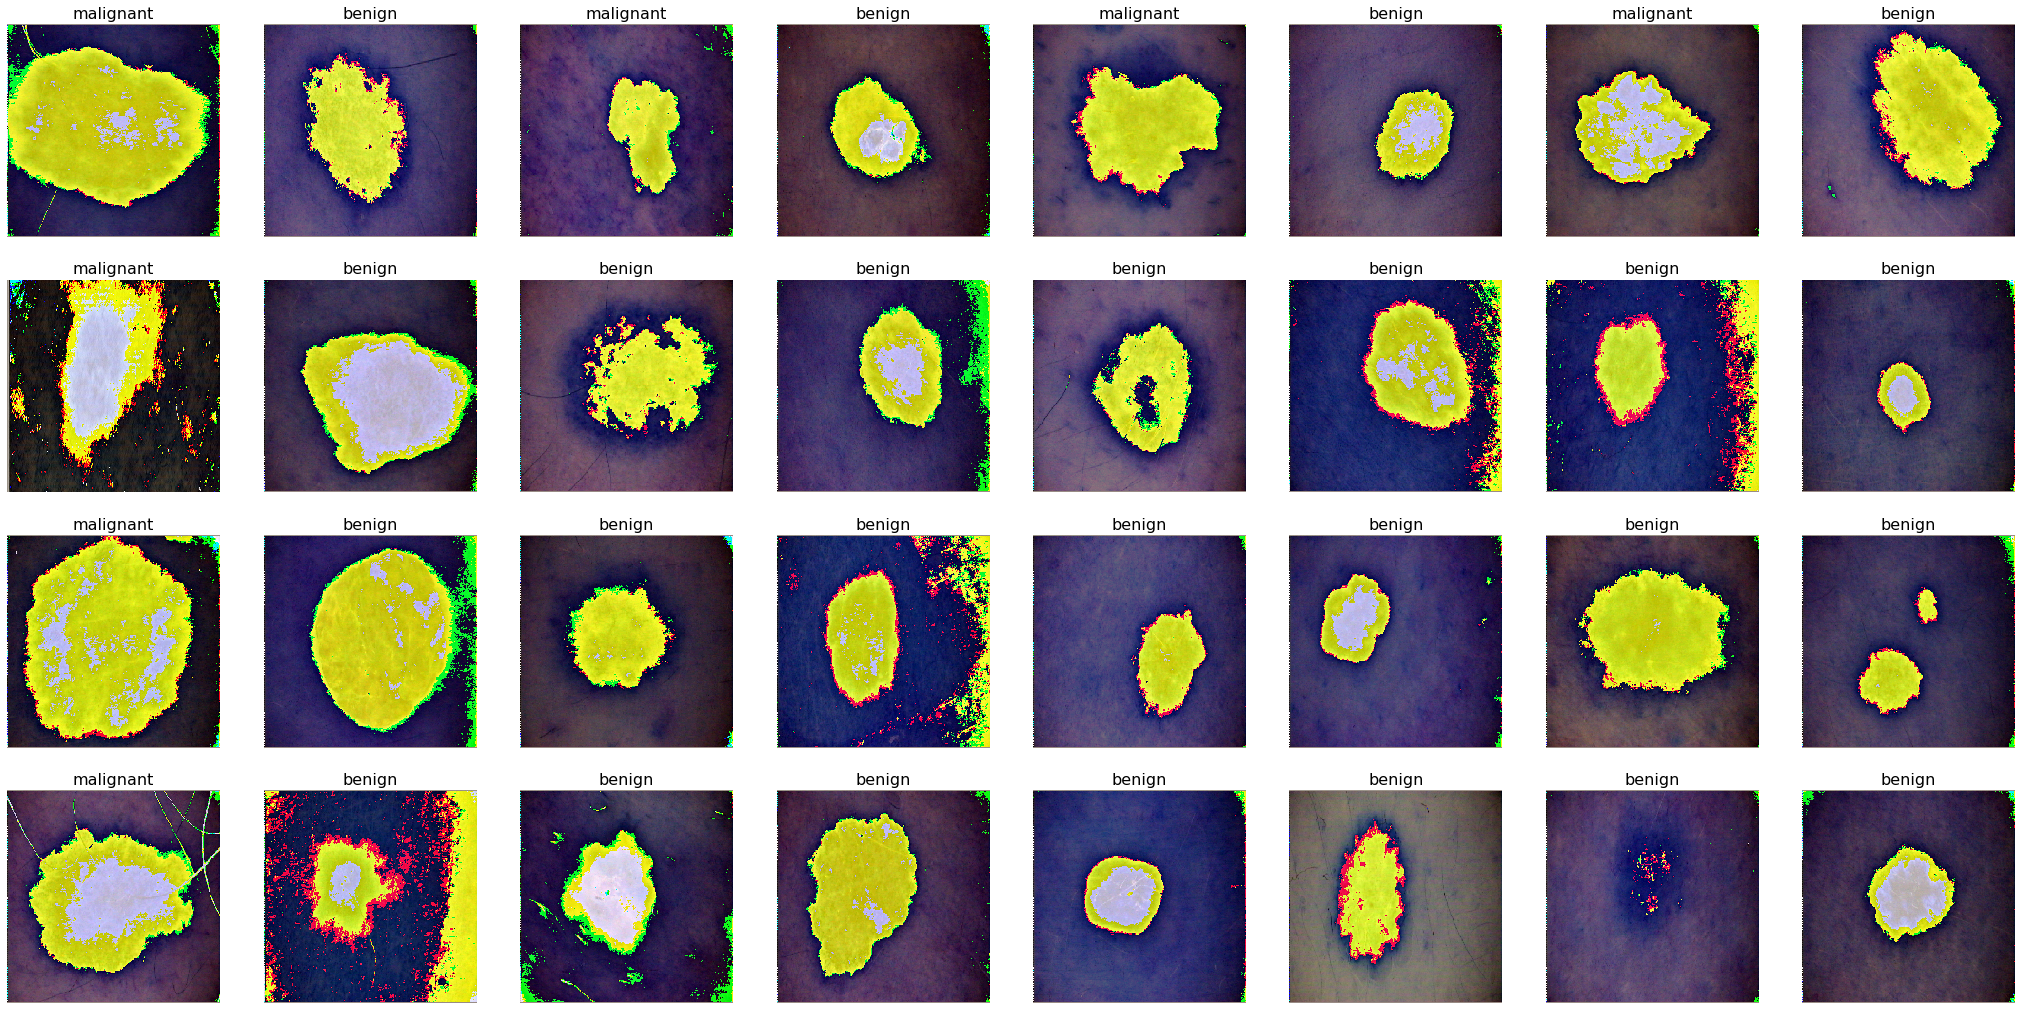

In [8]:
class_dict = train_batches.class_indices
imgs, labels = next(train_batches)
titles = ['benign' if x[class_dict['benign']]==1 else 'malignant' for x in labels]
plots(imgs, figsize=(36,18), titles=titles, rows=4)

In [9]:
prior_model = vgg16.VGG16(weights='imagenet',include_top=False, input_shape=(224,224,3))

In [10]:
model = Sequential()
model.add(prior_model)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 21,137,986
Non-trainable params: 0
_________________________________________________________________


In [13]:
for layers in model.layers[0].layers: # looping over each layers in layer 0 to freeze them
  layers.trainable = False

model.layers[0].trainable = False

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 256)               6422784   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 514       
Total params: 21,137,986
Trainable params: 6,423,298
Non-trainable params: 14,714,688
_________________________________________________________________


In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
model.fit(train_batches, steps_per_epoch=len(train_batches.filenames)//32, epochs=20, validation_data = test_batches, validation_steps=len(test_batches.filenames)//32 )

Epoch 1/20
68/68 [==============================] - 104s 1s/step - loss: 7.8867 - accuracy: 0.6996 - val_loss: 0.4604 - val_accuracy: 0.7917
Epoch 2/20
68/68 [==============================] - 36s 530ms/step - loss: 0.4308 - accuracy: 0.7910 - val_loss: 0.4951 - val_accuracy: 0.7986
Epoch 3/20
68/68 [==============================] - 37s 542ms/step - loss: 0.3812 - accuracy: 0.8005 - val_loss: 0.4692 - val_accuracy: 0.7986
Epoch 4/20
68/68 [==============================] - 37s 547ms/step - loss: 0.3185 - accuracy: 0.8181 - val_loss: 0.4989 - val_accuracy: 0.7986
Epoch 5/20
68/68 [==============================] - 38s 554ms/step - loss: 0.2363 - accuracy: 0.8905 - val_loss: 0.5611 - val_accuracy: 0.7812
Epoch 6/20
68/68 [==============================] - 36s 533ms/step - loss: 0.2052 - accuracy: 0.9136 - val_loss: 0.6459 - val_accuracy: 0.7778
Epoch 7/20
68/68 [==============================] - 35s 522ms/step - loss: 0.1423 - accuracy: 0.9429 - val_loss: 0.6856 - val_accuracy: 0.7639
E

In [23]:
acc = model.history.history['accuracy']
val_acc = model.history.history['val_accuracy']

loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

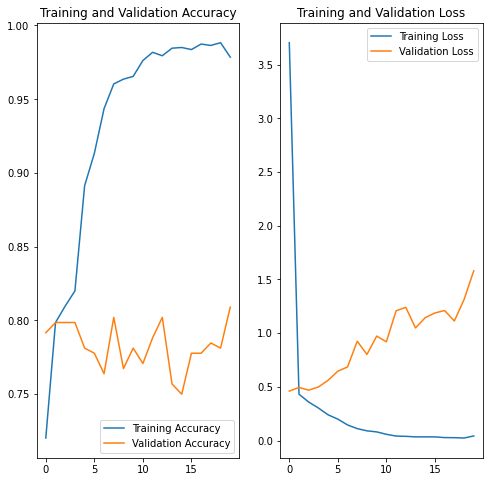

In [24]:
epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
